<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> Boosting Insights: Insurance Cross-Selling with XGBoost </b></div>

![car_crush](https://i.postimg.cc/cCXb4cRM/freepik-expand-96882.png)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> Introduction </b></div>

In this project, we explore the **2024 Kaggle Playground Series: Automobile Insurance Cross-Selling Prediction**. The goal is to predict whether a customer will respond positively to an automobile insurance offer, leveraging synthetic yet realistic datasets provided by Kaggle. The dataset offers a unique opportunity to sharpen skills in data exploration, feature engineering, and machine learning using advanced models like XGBoost. Submissions are evaluated using the ROC-AUC metric, focusing on predicted probabilities to ensure robust model performance.

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> Table of Contents </b></div>

- <a href="#libraries">1. Installing Required Libraries</a>
- <a href="#data">2. Reading and Understanding our Data</a>
- <a href="#memory">3. Memory Optimization Strategy</a>
- <a href="#visual">4. Data Visualization</a>
    - <a href="#corr">4.1. Exploring Correlation</a>
    - <a href="#num">4.2. Distribution of Numerical Features</a>
    - <a href="#cat">4.3. Distribution of Categorical Features</a>    
    - <a href="#response">4.4. Distribution of a Target variable</a> 
- <a href="#prepr">5. Data Engineering and Data Preprocessing</a>
    - <a href="#enc">5.1. Encoding categorical variables</a>
    - <a href="#sep">5.2. Separate features and target</a>
    - <a href="#scale">5.3. Data Scaling</a>
    - <a href="#split">5.4. Train / Test Split</a>      
- <a href="#ml">6. Machine Learning - XGBoost</a> 
- <a href="#submission">7. Submission</a> 

<a id="libraries"></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a;overflow:hidden"><b>1. Installing Required Libraries</b></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

<a id="data"></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a;overflow:hidden"><b>2. Reading and Understanding our Data</b></div>

Let's read the data into *pandas* dataframes and look at the first 5 rows using the `head()` method. 

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [5]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


Let's find out how many entries there are in our train datasets, using `shape` function.

In [7]:
train.shape

(11504798, 12)

Using `dtypes` function, we will take a look at our column names and types of data.

In [8]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Calculate the number of **duplicate rows** in the DataFrame df based on the 'id' column.

In [9]:
len(train[train.duplicated(['id'])])

0

All values in `id` column are unique, let's drop the column.

In [ ]:
train.drop('id', axis=1, inplace=True)

Below, we will check for any **missing values**.


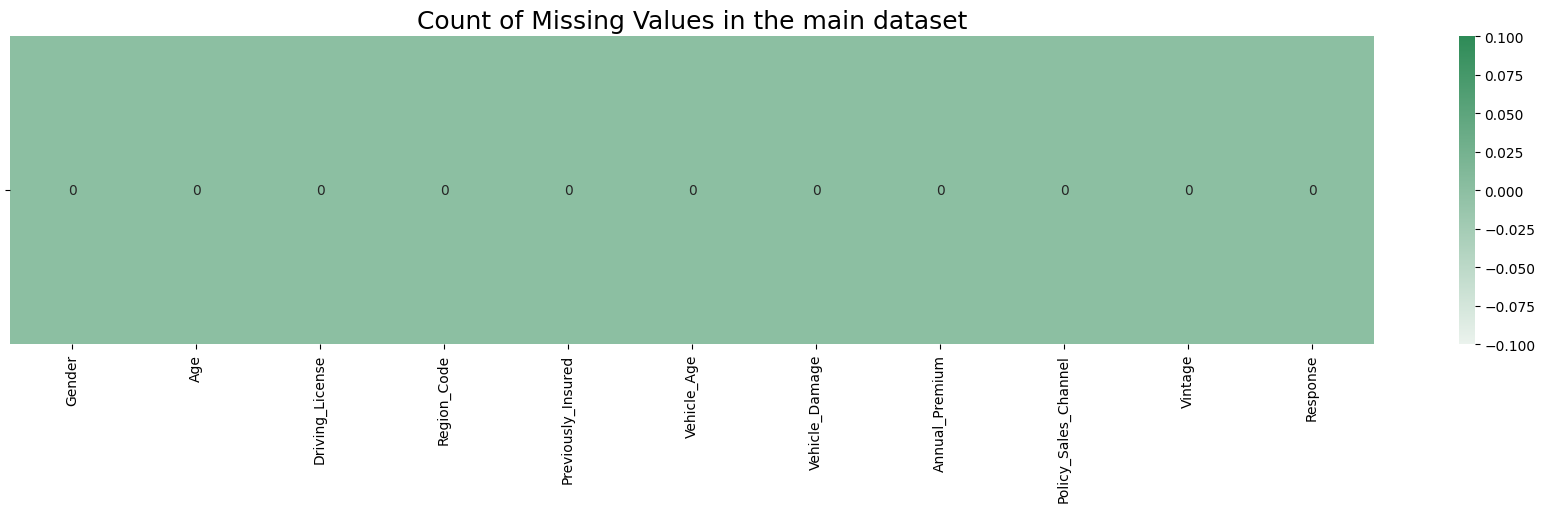

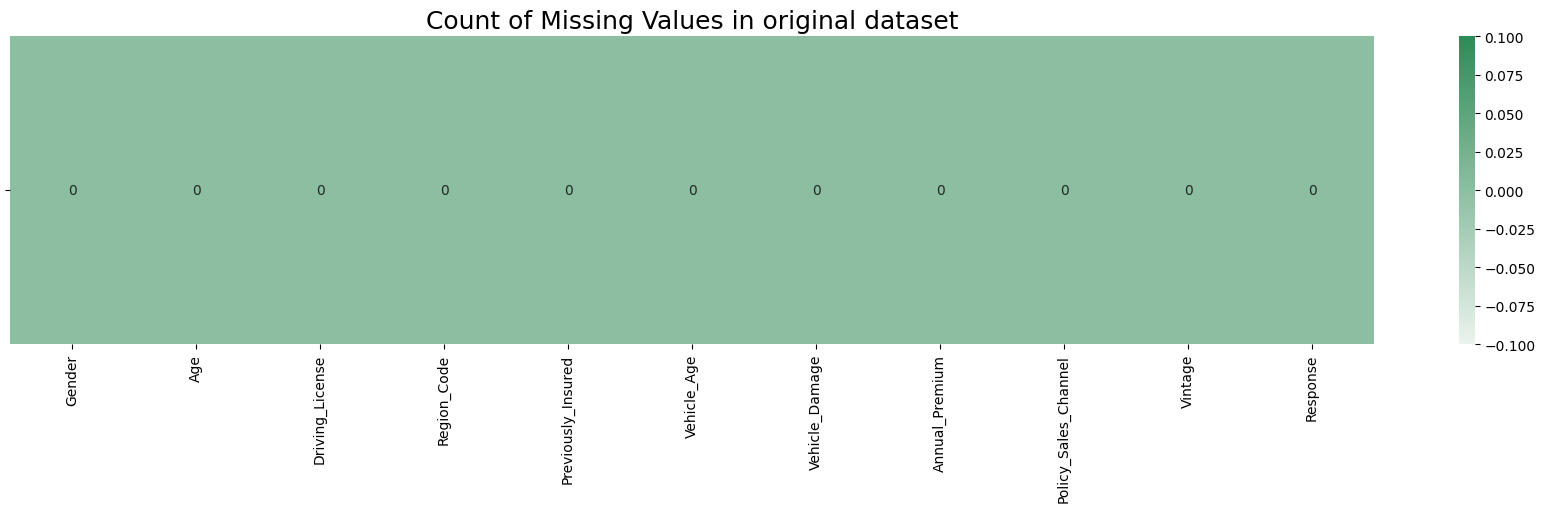

In [ ]:
# Create a custom color map using a light palette with the color "seagreen"
cmap = sns.light_palette("seagreen", as_cmap=True)

# Create a heatmap to visualize the count of missing values in the main DataFrame
plt.figure(figsize=(max(22, 11), 4))
sns.heatmap(
    (train.isna().sum()).to_frame(name='').T, 
    cmap=cmap, 
    annot=True, 
    fmt='0.0f'
).set_title('Count of Missing Values in the main dataset', fontsize=18)
plt.show()

Let's examine the **unique values** and their proportional counts in the categorical columns:

In [13]:
train.Gender.value_counts(normalize=True)

Gender
Male      0.541351
Female    0.458649
Name: proportion, dtype: float64

In [14]:
train.Vehicle_Age.value_counts(normalize=True)

Vehicle_Age
1-2 Year     0.520016
< 1 Year     0.438438
> 2 Years    0.041546
Name: proportion, dtype: float64

In [15]:
train.Vehicle_Damage.value_counts(normalize=True)

Vehicle_Damage
Yes    0.50268
No     0.49732
Name: proportion, dtype: float64

Now, let's provide **descriptive statistics** for numerical data in a concise manner. 

In [16]:
train.describe().iloc[1:]

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
mean,38.383563,0.998022,26.41869,0.462997,30461.370411,112.425442,163.897744,0.122997
std,14.993459,0.044431,12.99159,0.498629,16454.745205,54.035708,79.979531,0.328434
min,20.000000,0.000000,0.00000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,24.000000,1.000000,15.00000,0.000000,25277.000000,29.000000,99.000000,0.000000
50%,36.000000,1.000000,28.00000,0.000000,31824.000000,151.000000,166.000000,0.000000
75%,49.000000,1.000000,35.00000,1.000000,39451.000000,152.000000,232.000000,0.000000
max,85.000000,1.000000,52.00000,1.000000,540165.000000,163.000000,299.000000,1.000000


Let's explore those who don't have driving licence:

In [18]:
train[train.Driving_License == 0].sample(20)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
10498532,Female,80,0,28.0,0,1-2 Year,Yes,51991.0,26.0,61,0
2526210,Female,68,0,29.0,0,> 2 Years,Yes,32457.0,3.0,276,1
11372027,Male,65,0,41.0,0,1-2 Year,No,54463.0,26.0,239,0
11305814,Female,84,0,1.0,1,1-2 Year,No,2630.0,124.0,242,0
1769341,Female,65,0,46.0,0,1-2 Year,Yes,43000.0,26.0,13,0
10991489,Male,61,0,48.0,0,1-2 Year,Yes,2630.0,26.0,153,0
10969147,Male,64,0,48.0,0,1-2 Year,Yes,2630.0,26.0,174,0
9185484,Male,58,0,28.0,0,1-2 Year,Yes,29795.0,26.0,120,0
10852966,Male,57,0,28.0,0,1-2 Year,Yes,23008.0,26.0,239,0
2452384,Female,64,0,8.0,1,1-2 Year,No,47018.0,26.0,101,0


In [19]:
train[train.Driving_License == 0].Gender.value_counts()

Gender
Male      17083
Female     5674
Name: count, dtype: int64

In [20]:
train[train.Driving_License == 0].Age.value_counts().head(10)

Age
68    1062
67    1054
72     945
65     943
76     908
69     906
73     900
64     898
63     887
66     833
Name: count, dtype: int64

In [21]:
train.Region_Code.nunique()

54

### <div style="text-align:center; border-radius:15px 40px; padding:10px; color:white; margin:0; font-size:90%; font-family:Arial; background-color:#0f7a7a;overflow:hidden"><b>   Initial Data Exploration Summary</b></div>

The `train` dataset contains over **11.5 million rows** and **12 columns**,  with all values **being non-null**. The dataset includes a mix of integers, floats, and strings. Here are the key observations:

- **Gender** and **Vehicle_damage** are binary catogories. In contrast, **Vehicle_Age** has three categories. Notably, only 4.1% of cars are over 2 years old.
- **Age**: 20 to 85 years, with average 38 years old.
- **Previously_Insured**: 46% were previously insured.
- **Annual_Premium**: 2.6 to 540 thousand with average 30 thousand.
- **Driving_License**: 99.8% have one.
- It appears that most individuals who own a car but **do not have a driving license** are males over 60. This could suggest that they purchased the car for their children or grandchildren but registered it in their own name, or they have someone else driving for them.
- The **Regional_Code** is a categorical variable, but we'll keep it as a numerical value to avoid creating 54 extra columns.

<a id="memory"></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a;overflow:hidden"><b>3. Memory Optimization Strategy</b></div>

We implement a function to convert data types to more memory-efficient alternatives. We are going to follow the following list about datatypes with Pandas in order to avoid data loss:

* int8: Ranges from -128 to 127.
* int16: Ranges from -32,768 to 32,767.
* int32: Ranges from -2,147,483,648 to 2,147,483,647.
* int64: Ranges from -9,223,372,036,854,775,808 to 9,223,372,036,854,775,807.
* float16 (Half-precision): Approximate decimal precision of 3 to 4 decimal digits.
* float32 (Single-precision): Approximate decimal precision of 7 to 9 decimal digits.
* float64 (Double-precision): Approximate decimal precision of 15 to 17 decimal digits.

In [22]:
def converting_datatypes(df):
    df = df.copy()
    try:
        # Converting data types
        df['Gender'] = df['Gender'].astype('category')
        df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
        df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category')
        df['Age'] = df['Age'].astype('int8')
        df['Driving_License'] = df['Driving_License'].astype('int8')
        df['Region_Code'] = df['Region_Code'].astype('int8')
        df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
        df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
        df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
        df['Vintage'] = df['Vintage'].astype('int16')
        df['Response'] = df['Response'].astype('int8')
        print(df.info(memory_usage='deep'))
    except KeyError as e:
        print(f"Error: {e} not found in DataFrame")
    except Exception as e:
        print(f"An error occurred: {e}")
    return df

We apply this function to our datasets:

In [ ]:
train = converting_datatypes(train)
test = converting_datatypes(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   int8    
 2   Driving_License       int8    
 3   Region_Code           int8    
 4   Previously_Insured    int8    
 5   Vehicle_Age           category
 6   Vehicle_Damage        category
 7   Annual_Premium        int32   
 8   Policy_Sales_Channel  int16   
 9   Vintage               int16   
 10  Response              int8    
dtypes: category(3), int16(2), int32(1), int8(5)
memory usage: 175.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                381109 non-null  category
 1   Age                   381109 non-null  int8    
 2   Driving_Lice

### <div style="text-align:center; border-radius:15px 40px; padding:10px; color:white; margin:0; font-size:90%; font-family:Arial; background-color:#0f7a7a;overflow:hidden"><b> Results of Memory Optimization</b></div>

After applying optimization strategy, the training set's memory usage reduced from 2.8 GB to 263.3 MB.

This represents a significant reduction in memory usage, making the datasets more manageable for analysis and modeling besides the amount of data we are working with.

<a id="visual"></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 4. Data Visualization</b></div>

<a id='corr'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 4.1. Exploring Correlation  </b></div>

In [24]:
# Calculate the correlation matrix for the DataFrame
z = train.corr(numeric_only=True)

# Create an interactive heatmap with text annotations and a custom color scale
fig = px.imshow(
    z, 
    text_auto=True, 
    aspect="auto", 
    color_continuous_scale="blugrn"
)

# Update the layout to include a title with custom styling
fig.update_layout(
    title="Correlation Heatmap",
    title_font_size=18,
    title_x=0.5,  # Center the title
    title_y=0.95  # Slightly adjust the title position
)

# Display the interactive heatmap
fig.show()

In [25]:
df_corr = train.corr(numeric_only=True)['Response'][:-1] # -1 to remove the last row which is Response
df_corr.sort_values()

Previously_Insured     -0.345930
Policy_Sales_Channel   -0.152733
Vintage                -0.015177
Driving_License         0.009197
Region_Code             0.012816
Annual_Premium          0.032261
Age                     0.122134
Name: Response, dtype: float64

<a id='num'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 4.2. Distribution of Numerical Features  </b></div>

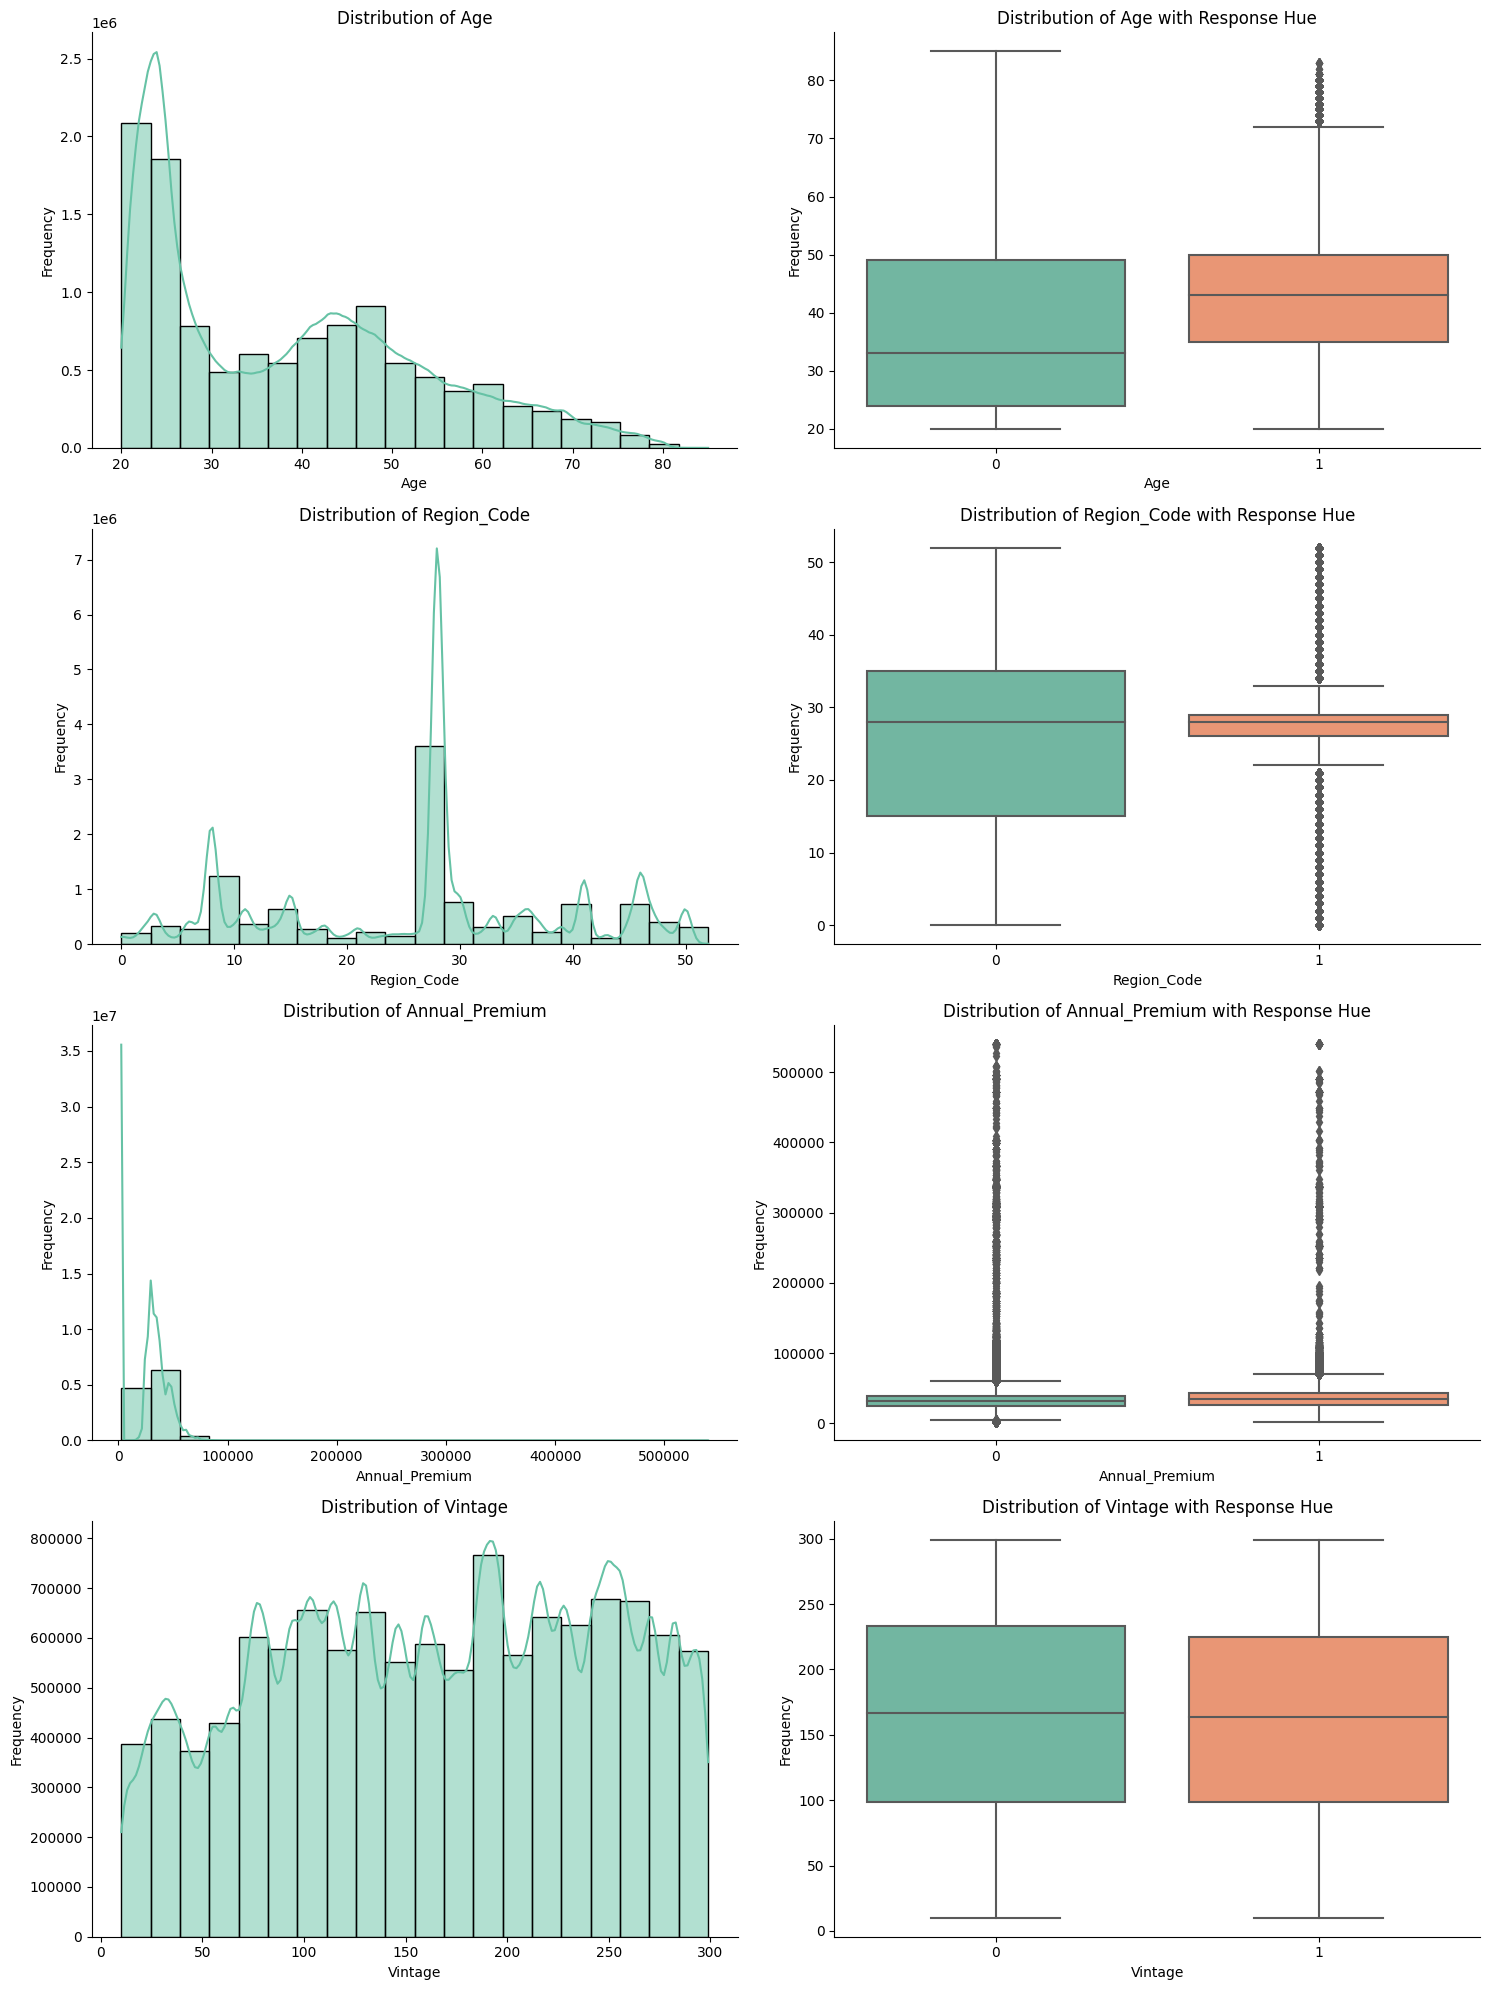

In [26]:
# Set Seaborn style
sns.set_palette("Set2")

# Select numerical features for visualization
numerical_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']

# Create subplots with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Iterate over each selected column
for i, column in enumerate(numerical_cols):
    # Plot without hue on the left
    sns.histplot(data=train, x=column, kde=True, bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

    # Plot with hue on the right
    sns.boxplot(data=train, y=column, x='Response', ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution of {column} with Response Hue')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Frequency')

sns.despine()
plt.tight_layout()
plt.show()


<a id='cat'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 4.3. Distribution of Categorical Features  </b></div>

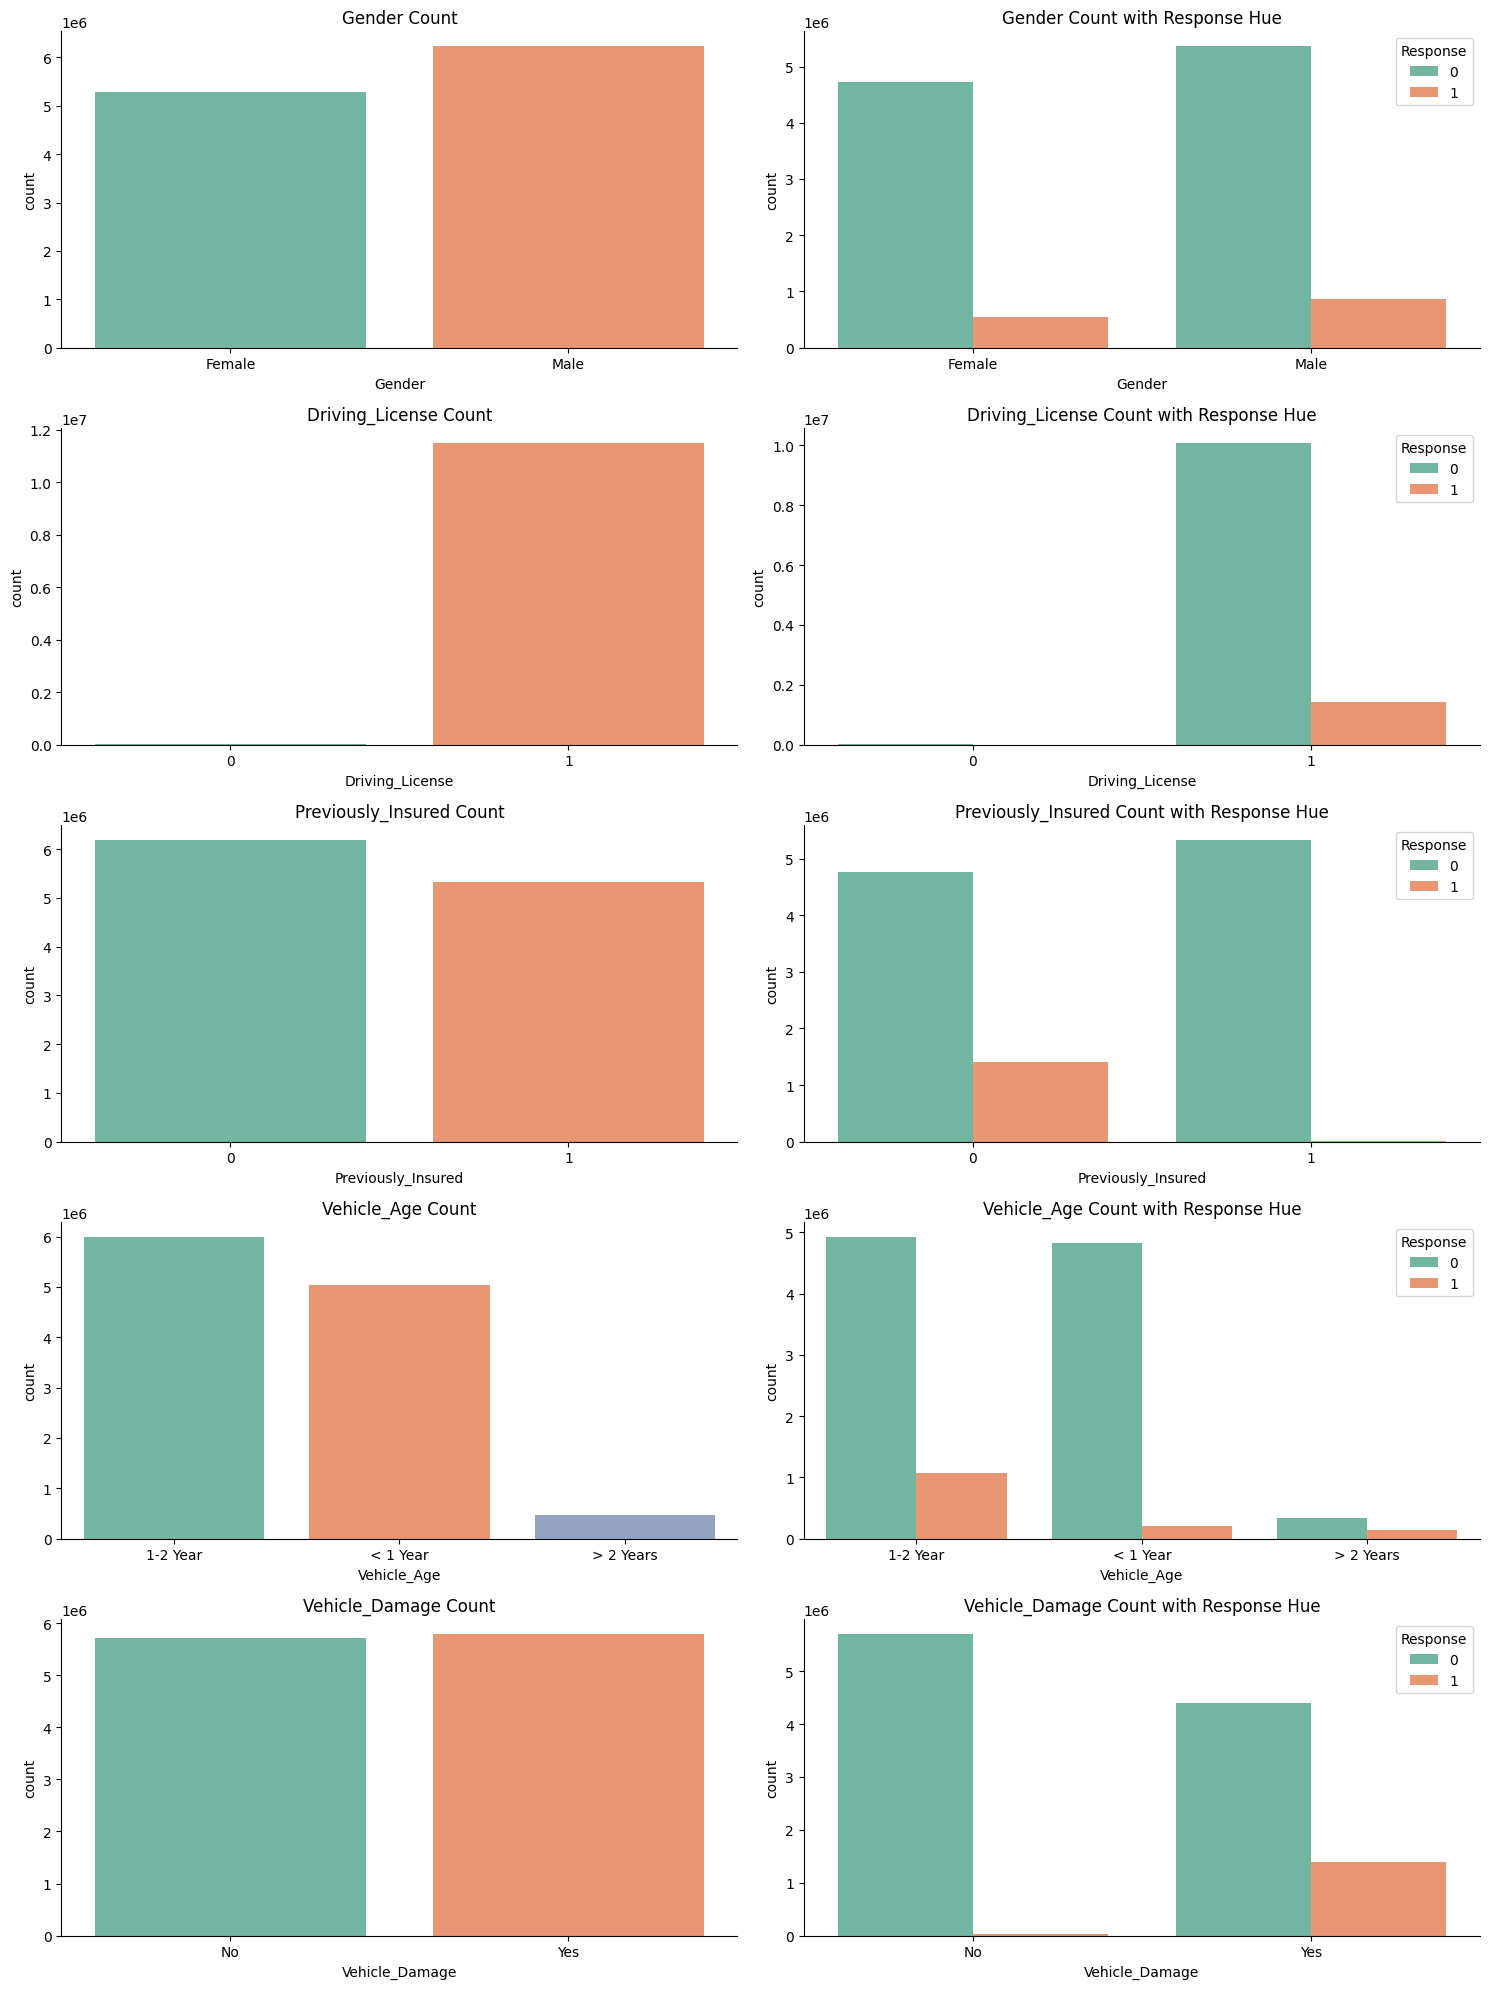

In [27]:
# Select categorical features for visualization
categorical_cols = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

# Create subplots with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Iterate over each selected column
for i, column in enumerate(categorical_cols):
    # Plot without hue on the left
    sns.countplot(x=column, data=train, ax=axes[i, 0])
    axes[i, 0].set_title(f'{column} Count')

    # Plot with hue on the right
    sns.countplot(x=column, hue='Response', data=train, ax=axes[i, 1])
    axes[i, 1].set_title(f'{column} Count with Response Hue')

sns.despine()
plt.tight_layout()
plt.show()


<a id='target'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 4.4. Distribution of a Target variable  </b></div>

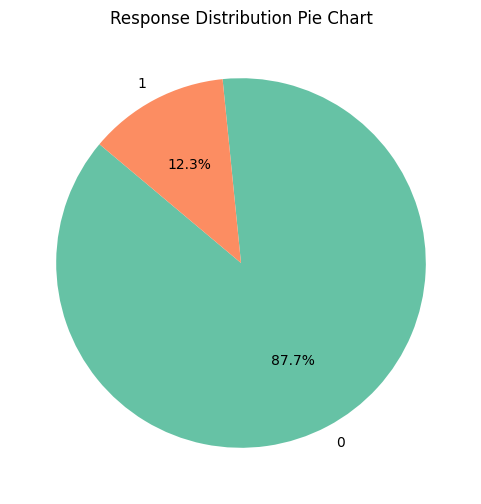

In [28]:
# Define the Response categories and count occurences
categories = [0, 1]
counts = train.Response.value_counts().tolist()

# Choose a color palette from Seaborn for the pie chart
colors = sns.color_palette("Set2")

# Plot the pie chart with the counts of each response category
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Response Distribution Pie Chart')
plt.show()

### <div style="text-align:center; border-radius:15px 40px; padding:10px; color:white; margin:0; font-size:90%; font-family:Arial; background-color:#0f7a7a;overflow:hidden"><b> Observations from Visualizations above</b></div>

- There is a negative correlation of -0.59 between the **Policy Sales Channel** and **Age**. Additionally, there is no strong correlation with the **Response** variable. The highest correlation with the **Response** variable is with the **Previously Insured** feature, which stands at -0.35.
- The **Age** variable exhibits a right-skewed distribution.
- The **Annual Premium** has a long right tail, indicating the presence of outliers.
- The **Vintage** variable follows a uniform distribution.
- Older individuals show a higher **Response** rate.
- There is a slight predominance of **men** over **women** in the dataset.
- The **Vehicle Damage** variable is evenly split, with 50% showing damage and 50% not showing damage.
- Our **Response** variable is imbalanced, with 87.7% of instances being 0 and only 12.3% being 1.

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 5. Data Engineering and Data Preprocessing</b></div>

<a id='enc'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 5.1. Encoding categorical variables</b></div>

Machine learning models require numerical inputs. Label encoding or one-hot encoding converts categorical variables into numerical representations while retaining their informational value.

In [29]:
# Define categorical columns to be one-hot encoded
categorical_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# Apply one-hot encoding directly with pandas
train_encoded = pd.get_dummies(train, columns=categorical_columns, drop_first=True, dtype=int)  

<a id='sep'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 5.2. Separate Features and Target</b></div>

In [30]:
# Separate features (X) and target variable (y)
X = train_encoded.loc[:, train_encoded.columns != "Response"]
y = train_encoded['Response']


<a id='scale'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 5.3. Data Scaling</b></div>

Scaling numerical features standardizes their range, helping models like XGBoost converge faster and handle features with varying scales more effectively.

In [31]:
# Standardize the features using StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(X)

# Transform the data
X_scaled = scaler.transform(X)

<a id='split'></a>
## <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> 5.4. Train / Test Split </b></div>

Separating training and testing data before preprocessing ensures that information from the test set does not leak into the training process, preserving model generalizability.

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

<a id='ml'></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>  6. Machine Learning - XGBoost</b></div>

Due to the imbalance in the response variable, we will use the `scale_pos_weight` parameter to adjust the weights of the classes, thereby balancing the dataset during model training.

In [33]:
xgb_params = {    
        'max_depth': 13, 
        'min_child_weight': 5,
        'learning_rate': 0.02,
        'colsample_bytree': 0.6,         
        'max_bin': 3000, 
        'n_estimators': 1500 
}

# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

# Initialize the XGBoost classifier with specified hyperparameters
model = XGBClassifier(**xgb_params, scale_pos_weight=ratio)

# Fit the classifier to the training data
XGB_model = model.fit(X_train, y_train)

# Make predictions on the test data
predictions = XGB_model.predict_proba(X_test)[:,1]

# Print the validation area under the curve
print("Validation Area Under the Curve (AUC): ", roc_auc_score(y_test, predictions))

Validation Area Under the Curve (AUC):  0.8852611681996535


<a id='submission'></a>

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b>  7. Submission</b></div>

In [34]:
# Extract 'id' column into test_ids
test_ids = test['id']

# Drop ids in the test file
test.drop('id', axis=1, inplace=True)

In [35]:
# Apply one-hot encoding directly with pandas
test_encoded = pd.get_dummies(test, columns=categorical_columns, drop_first=True, dtype=int)  

# Transform the `test` data using the same scaler as `train`
test_scaled = scaler.transform(test_encoded)

# Make predictions on the test data
predictions_test = XGB_model.predict_proba(test_scaled)[:,1]

In [ ]:
# result dataframe
result = pd.DataFrame({'id' : test_ids, 'Response' : predictions_test.flatten()}, 
                      columns=['id', 'Response'])

# Save the df as csv
result.to_csv("submission.csv",index=False)

**The final submission achieved an impressive ROC-AUC score of 0.886, securing a spot in the top 25% of all competition participants.**

<a id='recommendations'></a>